In [1]:
import argparse, random, os
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from clip_illusion import Illusion
from utils.model_utils import load_vision_model
from utils.objectives import ClassConditionalObjective
from utils.config import Domain2Dict
from utils.feature_manipulation import counterfactual_explanation
from train_test_classifier import load_test_data, eval_loop
from scripts.inspect_class_mistakes import inspect_mistakes_in_class, vote_topk, aggregate_vote

In [2]:
domain_name = "flowers"
class_dict = Domain2Dict[domain_name]

def prepare_model_and_illusion(model_name, device_id, class_gamma=0.35, domain_eps=0.05, ckpt_path=None):
    device = torch.device(f"cuda:{device_id}")
    transform, model, pool, decision, config = load_vision_model(model_name, device=device, ckpt_path=ckpt_path)
    illusion = Illusion(model, decision, ClassConditionalObjective(image_size=224, class_gamma=class_gamma, domain_eps=domain_eps), \
        class_dict=class_dict, device=f"cuda:{device_id}", img_mean=config["mean"], img_std=config["std"])
    
    return model, illusion, {"transform": transform, "pool": pool, "decision": decision}

def inference_one_sample(model, image_path, device):
    image = Image.open(image_path).convert("RGB")
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0).to(device)
    
    logits = model(image)
    pred = torch.argmax(logits, dim=-1)[0].item()
    
    return pred

In [3]:
device_id = 1
class_gamma = 0.5
domain_eps = 0.1
model_name = "resnet50"
ckpt_path = "ckpt/flowers102_resnet50/check_88.63.pt"

# Prepare model and CLIP-Illusion
model, illusion, modules = prepare_model_and_illusion(model_name, device_id, class_gamma, domain_eps, ckpt_path)
dimension = modules["decision"].weight.data.shape[1]

dataset_name = "flowers102"
data_dir= "data"
batch_size = 128

# Prepare test dataset
test_dataset, classes = load_test_data(dataset_name, data_dir, split="valid")
print("> The number of test samples: %d" % len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
img_filelist = test_dataset._image_files

> The number of test samples: 1020


In [4]:
class_idx = 3

# set device
device = torch.device(device_id)

# Test the model
mistake_samples, imp, inc_feats, cor_feats = inspect_mistakes_in_class(class_idx, test_loader, img_filelist, model, device)
num_mistakes = len(mistake_samples)
print(f"> {model_name} has {num_mistakes} mistakes for the {dataset_name} dataset.")

Evaluating: 8it [00:03,  2.30it/s]

> resnet50 has 6 mistakes for the flowers102 dataset.


In [5]:
mean_class_vector = (cor_feats.sum(dim=0) + inc_feats.sum(dim=0)) / (cor_feats.shape[0] + inc_feats.shape[0])

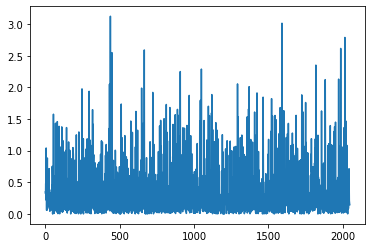

In [6]:
import matplotlib.pyplot as plt

x = range(2048)
plt.plot(x, mean_class_vector.cpu())

In [7]:
n_id = 1540
print(cor_feats[:, n_id].mean(), cor_feats[:, n_id].var())
print(inc_feats[:, n_id].mean(), inc_feats[:, n_id].var())

tensor(0.1349, device='cuda:1') tensor(0.0402, device='cuda:1')
tensor(0.0366, device='cuda:1') tensor(0.0007, device='cuda:1')


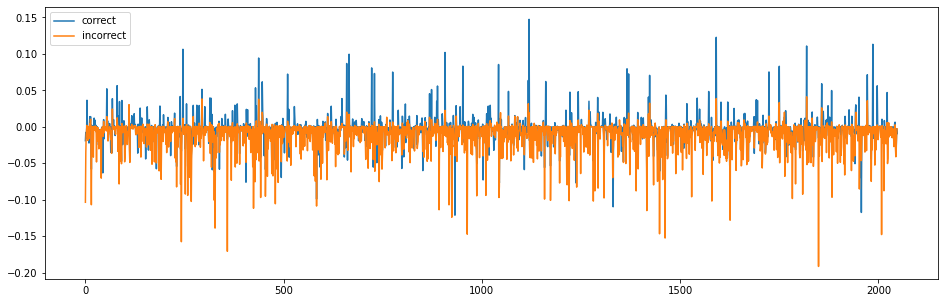

In [8]:
import matplotlib.pyplot as plt

cor_logits = modules["decision"].weight.data[class_idx].unsqueeze(0) * cor_feats
inc_logits = modules["decision"].weight.data[class_idx].unsqueeze(0) * inc_feats

s1 = cor_logits.min(dim=0)[0]
s2 = inc_logits.min(dim=0)[0]
plt.figure(figsize=(16, 5))
x = range(2048)
plt.plot(x, s1.cpu(), label="correct")
plt.plot(x, s2.cpu(), label="incorrect")
plt.legend();

In [9]:
class_dict = Domain2Dict[domain_name]
class_name = class_dict[class_idx].split(", ")[-1]

# Counterfactual explanation
print(f"> Inspecting mistakes for {class_name}...")
adjust_w = counterfactual_explanation(mistake_samples, modules["transform"], model, modules["pool"], \
                                    modules["decision"], device, class_idx=class_idx)
pos_vote = vote_topk(adjust_w, neg=False, k=5)
neg_vote = vote_topk(adjust_w, neg=True, k=5)
total_topk_pos = aggregate_vote(pos_vote, adjust_w.shape[0])
total_topk_neg = aggregate_vote(neg_vote, adjust_w.shape[0])
pos_ids = total_topk_pos.keys()
neg_ids = total_topk_neg.keys()

folder_class_name = class_name.replace(" ", "_")
exp_name = f"debug_{model}_{dataset_name}_{folder_class_name}"

print("\n<Underlying Reasons>")
    
print("\n- Insufficient Properties:")
print(" Rank    ID  Prec@10 %  Importance")
print("--------------------------------")
skip = 0
for r, (n_id, v) in enumerate(total_topk_pos.items()):
    if n_id in neg_ids:
        skip+=1
        continue
    if r >= 15:
        break
    print("Top-%d: %4d  %2.3f   %.4f" % (r+1-skip, n_id, v, imp[n_id]))
print("--------------------------------")
        
print("\n- Excessive Properties:")
print(" Rank    ID  Prec@10 %  Importance")
print("--------------------------------")
skip = 0
for r, (n_id, v) in enumerate(total_topk_neg.items()):
    if n_id in pos_ids:
        skip+=1
        continue
    if r >= 15:
        break
    print("Top-%d: %4d  %2.3f   %.4f" % (r+1-skip, n_id, v, imp[n_id]))
print("--------------------------------\n")

> Inspecting mistakes for sweet pea...
Progress 100.00 Optimizing iteration: 21, top neuron: 1097   

<Underlying Reasons>

- Insufficient Properties:
 Rank    ID  Prec@10 %  Importance
--------------------------------
Top-1: 1942  83.333   1.0273
Top-2:  138  66.667   1.0224
Top-3:  989  50.000   1.0119
Top-4:  123  33.333   1.0172
Top-5:  974  33.333   1.0102
Top-6: 1846  16.667   1.0152
Top-7: 1518  16.667   1.0157
Top-8: 1142  16.667   1.0157
Top-9: 1097  16.667   1.0215
Top-10:  489  16.667   1.0239
Top-11: 1280  16.667   1.0147
Top-12:  575  16.667   1.0152
Top-13:  935  16.667   1.0290
Top-14: 1347  16.667   1.0096
Top-15:  665  16.667   1.0300
--------------------------------

- Excessive Properties:
 Rank    ID  Prec@10 %  Importance
--------------------------------
Top-1: 1448  66.667   0.9799
Top-2: 1043  66.667   0.9703
Top-3:  931  66.667   0.9707
Top-4:  497  33.333   0.9931
Top-5:  708  33.333   0.9901
Top-6: 1135  33.333   0.9862
Top-7: 1092  33.333   0.9759
Top-8:  872

In [13]:
from utils.prompts import prepare_class_names

target_neurons = torch.LongTensor([123, 1846, 1942, 138])

# set neuron idx
illusion.objective_fn.channel_number = target_neurons.to(device)
class_indices = torch.LongTensor([class_idx for _ in range(target_neurons.shape[0])]).to(device)
illusion.objective_fn.class_idx = class_indices
# Generate Feature
class_names = prepare_class_names(class_indices, class_dict)

# Generate CLIP-Illusion
images, acts, masks = illusion.optimize_caption_and_dream(model.layer4, batch_size=target_neurons.shape[0], thresholding=False, \
                lr=9e-3, weight_decay=2e-4, iters=450, texts=class_names, quiet=False, reduction=0.5, threshold=0.5)

100%|██████████| 450/450 [00:22<00:00, 20.32it/s, loss=-3.23, lr=0.00108]


In [14]:
# torch.softmax(model(illusion.postprocess(images)), dim=-1)[:, class_idx]
probs = torch.softmax(model(illusion.postprocess(images)), dim=-1)
print(torch.argmax(probs,dim=1))
print(class_indices)
print(torch.gather(probs, 1, class_indices.unsqueeze(-1)).squeeze(1))

tensor([3, 3, 3, 3], device='cuda:1')
tensor([3, 3, 3, 3], device='cuda:1')
tensor([0.9999, 0.9999, 1.0000, 1.0000], device='cuda:1',
       grad_fn=<SqueezeBackward1>)


In [15]:
from scripts.debug_mistakes_per_class import select_spurious_attribute

selected = select_spurious_attribute(model, illusion, images, acts, masks, cor_feats, inc_feats, 1)
selected.shape

tensor([0.6670, 0.6191, 0.5935, 0.7432], device='cuda:1')
tensor([0.7037, 0.4674, 0.6837, 0.7623], device='cuda:1')
tensor([1.0549, 0.7549, 1.1520, 1.0258], device='cuda:1')


torch.Size([4])

In [16]:
selected

tensor([False,  True, False, False], device='cuda:1')

/opt/conda/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


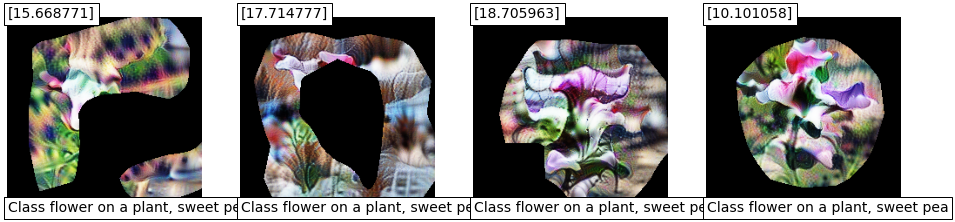

In [17]:
import matplotlib.pyplot as plt
from utils.ops import to_rgb
from PIL import Image

_images = to_rgb((images*(masks)).cpu().detach())
_acts = acts.cpu().detach().numpy()
neurons = target_neurons.tolist()

pil_images = [Image.fromarray(_images[i], "RGB") for i in range(len(neurons))]

fig, axes = plt.subplots(1,len(neurons))

fig.set_figheight(4)
fig.set_figwidth(4*len(neurons))

for i in range(len(neurons)):
    axes[i].imshow(pil_images[i]);
    axes[i].axis(False);
    axes[i].text(0.5, 0.5, _acts[i], fontsize=14, bbox=dict(facecolor="white"));
    axes[i].text(0.5, 224, "Class "+class_names[i].split(",")[0], fontsize=14, bbox=dict(facecolor="white"));
    axes[i].text(0.5, 224, f"Class {class_names[i]}", fontsize=14, bbox=dict(facecolor="white"));

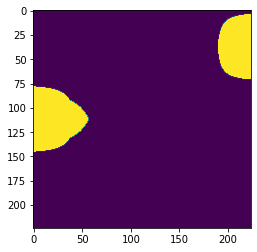

In [21]:
plt.imshow((masks[5,0]).cpu().detach())


In [22]:
# probs_pos = torch.softmax(model(illusion.postprocess(images*masks)),dim=-1)
# print(torch.gather(probs_pos, 1, class_indices.unsqueeze(-1)).squeeze(1))
probs_neg = torch.softmax(model(illusion.postprocess(images*(1.-masks))),dim=-1)
print(torch.gather(probs_neg, 1, class_indices.unsqueeze(-1)).squeeze(1))
probs = probs/probs_neg
# print(torch.argmax(probs,dim=1))
print(class_indices)
print(torch.gather(probs, 1, class_indices.unsqueeze(-1)).squeeze(1))

tensor([1.0000, 0.9984, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1', grad_fn=<SqueezeBackward1>)
tensor([93, 93, 93, 93, 93, 93, 93, 93, 93, 93], device='cuda:1')
tensor([1.0000, 1.0016, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1', grad_fn=<SqueezeBackward1>)


torch.Size([4, 3, 224, 224])